In [1]:
import glob
import matplotlib.pyplot as plt
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!cp /content/drive/'My Drive'/JIMUT_MAPS.zip .

In [4]:
!unzip -qq JIMUT_MAPS.zip

In [5]:
!mv JIMUT_MAPS/* .

In [6]:
import glob
roads = glob.glob('roads/*.png')
print("Total # of files => ",len(roads))
map = glob.glob('map/*.jpeg')
print("Total # of files => ",len(map))

Total # of files =>  236606
Total # of files =>  236606


In [22]:
# make the ds small
from PIL import Image
import os
import numpy as np
from tqdm import tqdm

for item in tqdm(roads):
  col = Image.open(item)
  gry = col.convert('L') # returns grayscale version.
  #get_img = cv2.imread(item, cv2.IMREAD_GRAYSCALE)
  arr = np.asarray(gry)
  tot = arr.sum(0).sum(0)
  if tot > 0:
    # keep the image, do nothing
    pass
  else:
    #print(item, "tot = ",tot)
    #img = cv2.imread(item,cv2.IMREAD_UNCHANGED)
    #plt.imshow(img) 
    get_map_list = str(item.split('/')[1]).split('_')
    #print(get_map_list)
    get_map = "map/"+get_map_list[0] +"_"+ get_map_list[1] + ".jpeg"
    #print(get_map)
    #img = cv2.imread(get_map,cv2.IMREAD_UNCHANGED)
    #plt.imshow(img[:,:,::-1]) 
    os.remove(item)
    os.remove(get_map)
    


100%|██████████| 236606/236606 [05:55<00:00, 664.92it/s]


In [23]:
import glob
roads = glob.glob('roads/*.png')
print("Total # of files => ",len(roads))
map = glob.glob('map/*.jpeg')
print("Total # of files => ",len(map))

Total # of files =>  61950
Total # of files =>  61950


In [24]:
roads.sort()
map.sort()

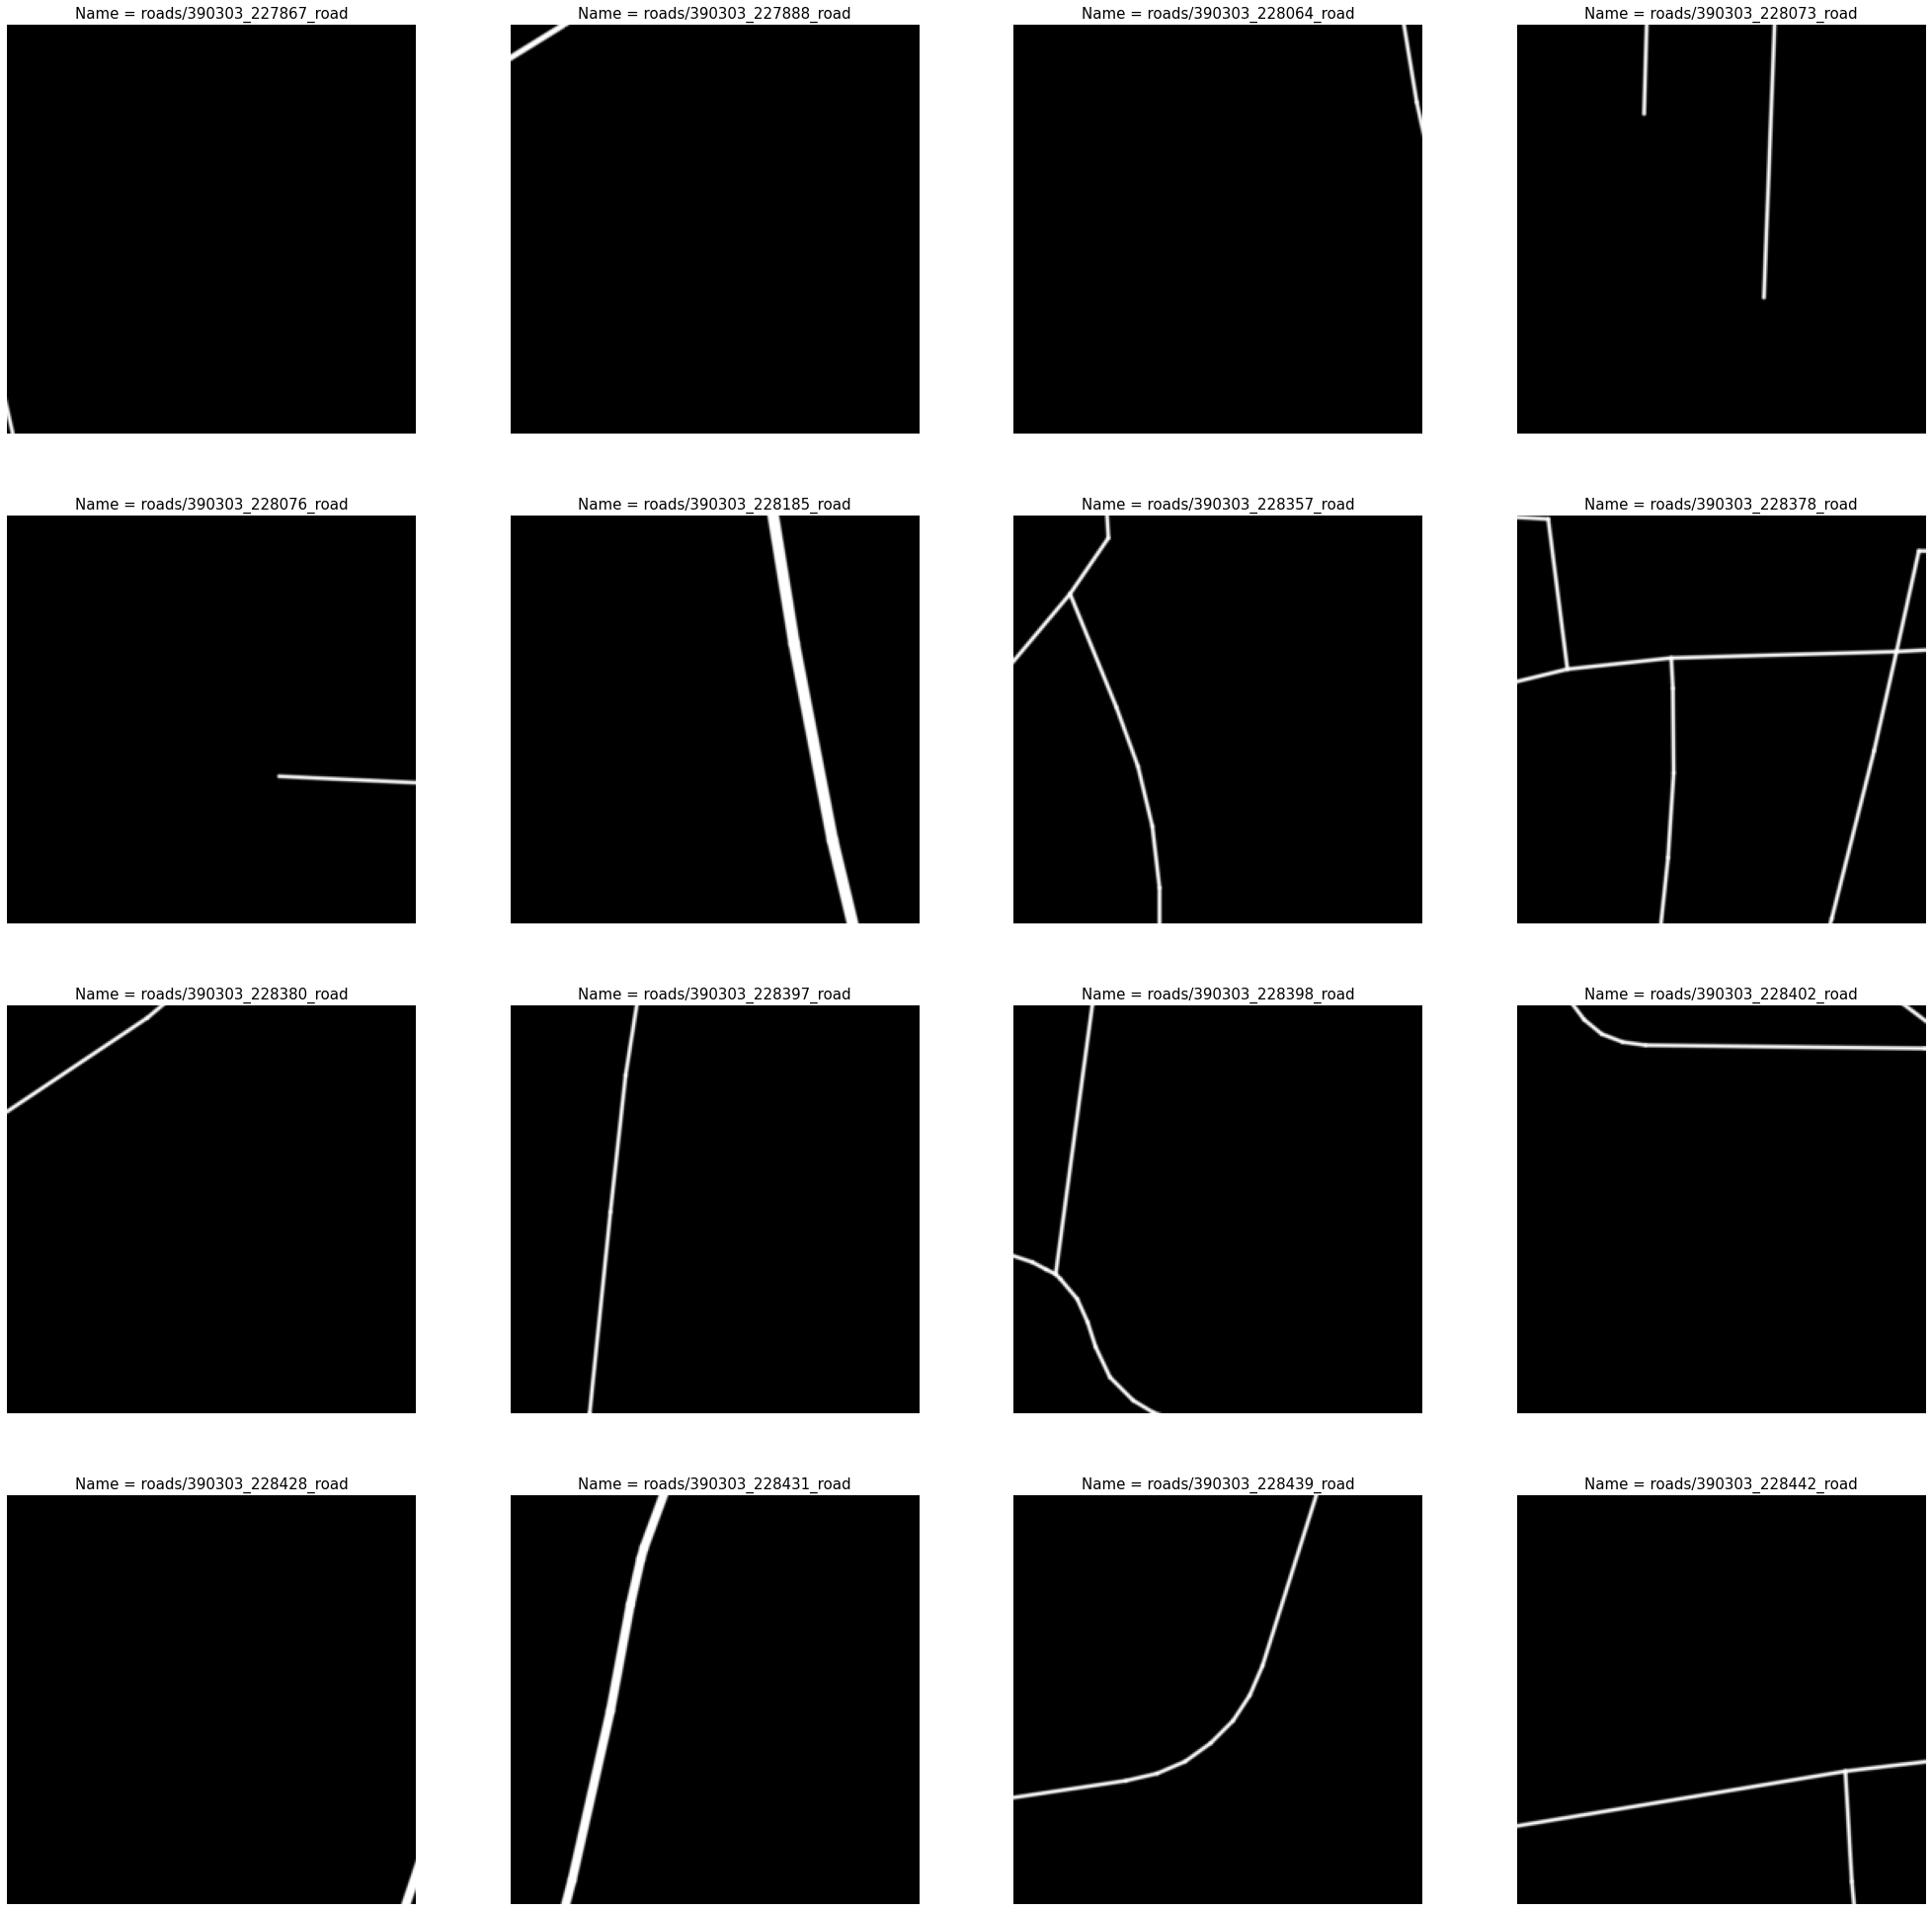

In [28]:
total_img = 16
num_pr = 4 # number per row

counter = 1
plt.figure(figsize=(35,35))
plt.axis('off')
for item in roads[:total_img]:
  image = cv2.imread(item, cv2.IMREAD_GRAYSCALE)
  #img = cv2.resize(img, (200,60), interpolation = cv2.INTER_AREA)
  #ret,thresh = cv2.threshold(image,127,255,cv2.THRESH_BINARY_INV)
  # firstly perform erosion
  #erosion = cv2.erode(thresh,kernel,iterations = 1)
  # perform dialation
  #dialate = cv2.dilate(erosion,kernel,iterations = 2)
  
  #print(pred)
  #image_bckup = dialate.copy()
  plt.subplot(num_pr, num_pr, counter)
  #print("item => ",item)
  #print("item => ",str(item.split('_')[1]).split('/')[1])
  plt.title("Name = {}".format(str(item.split('.')[0])),fontsize=15).set_color('black')
  plt.axis('off')
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  counter += 1
  #break
plt.show()

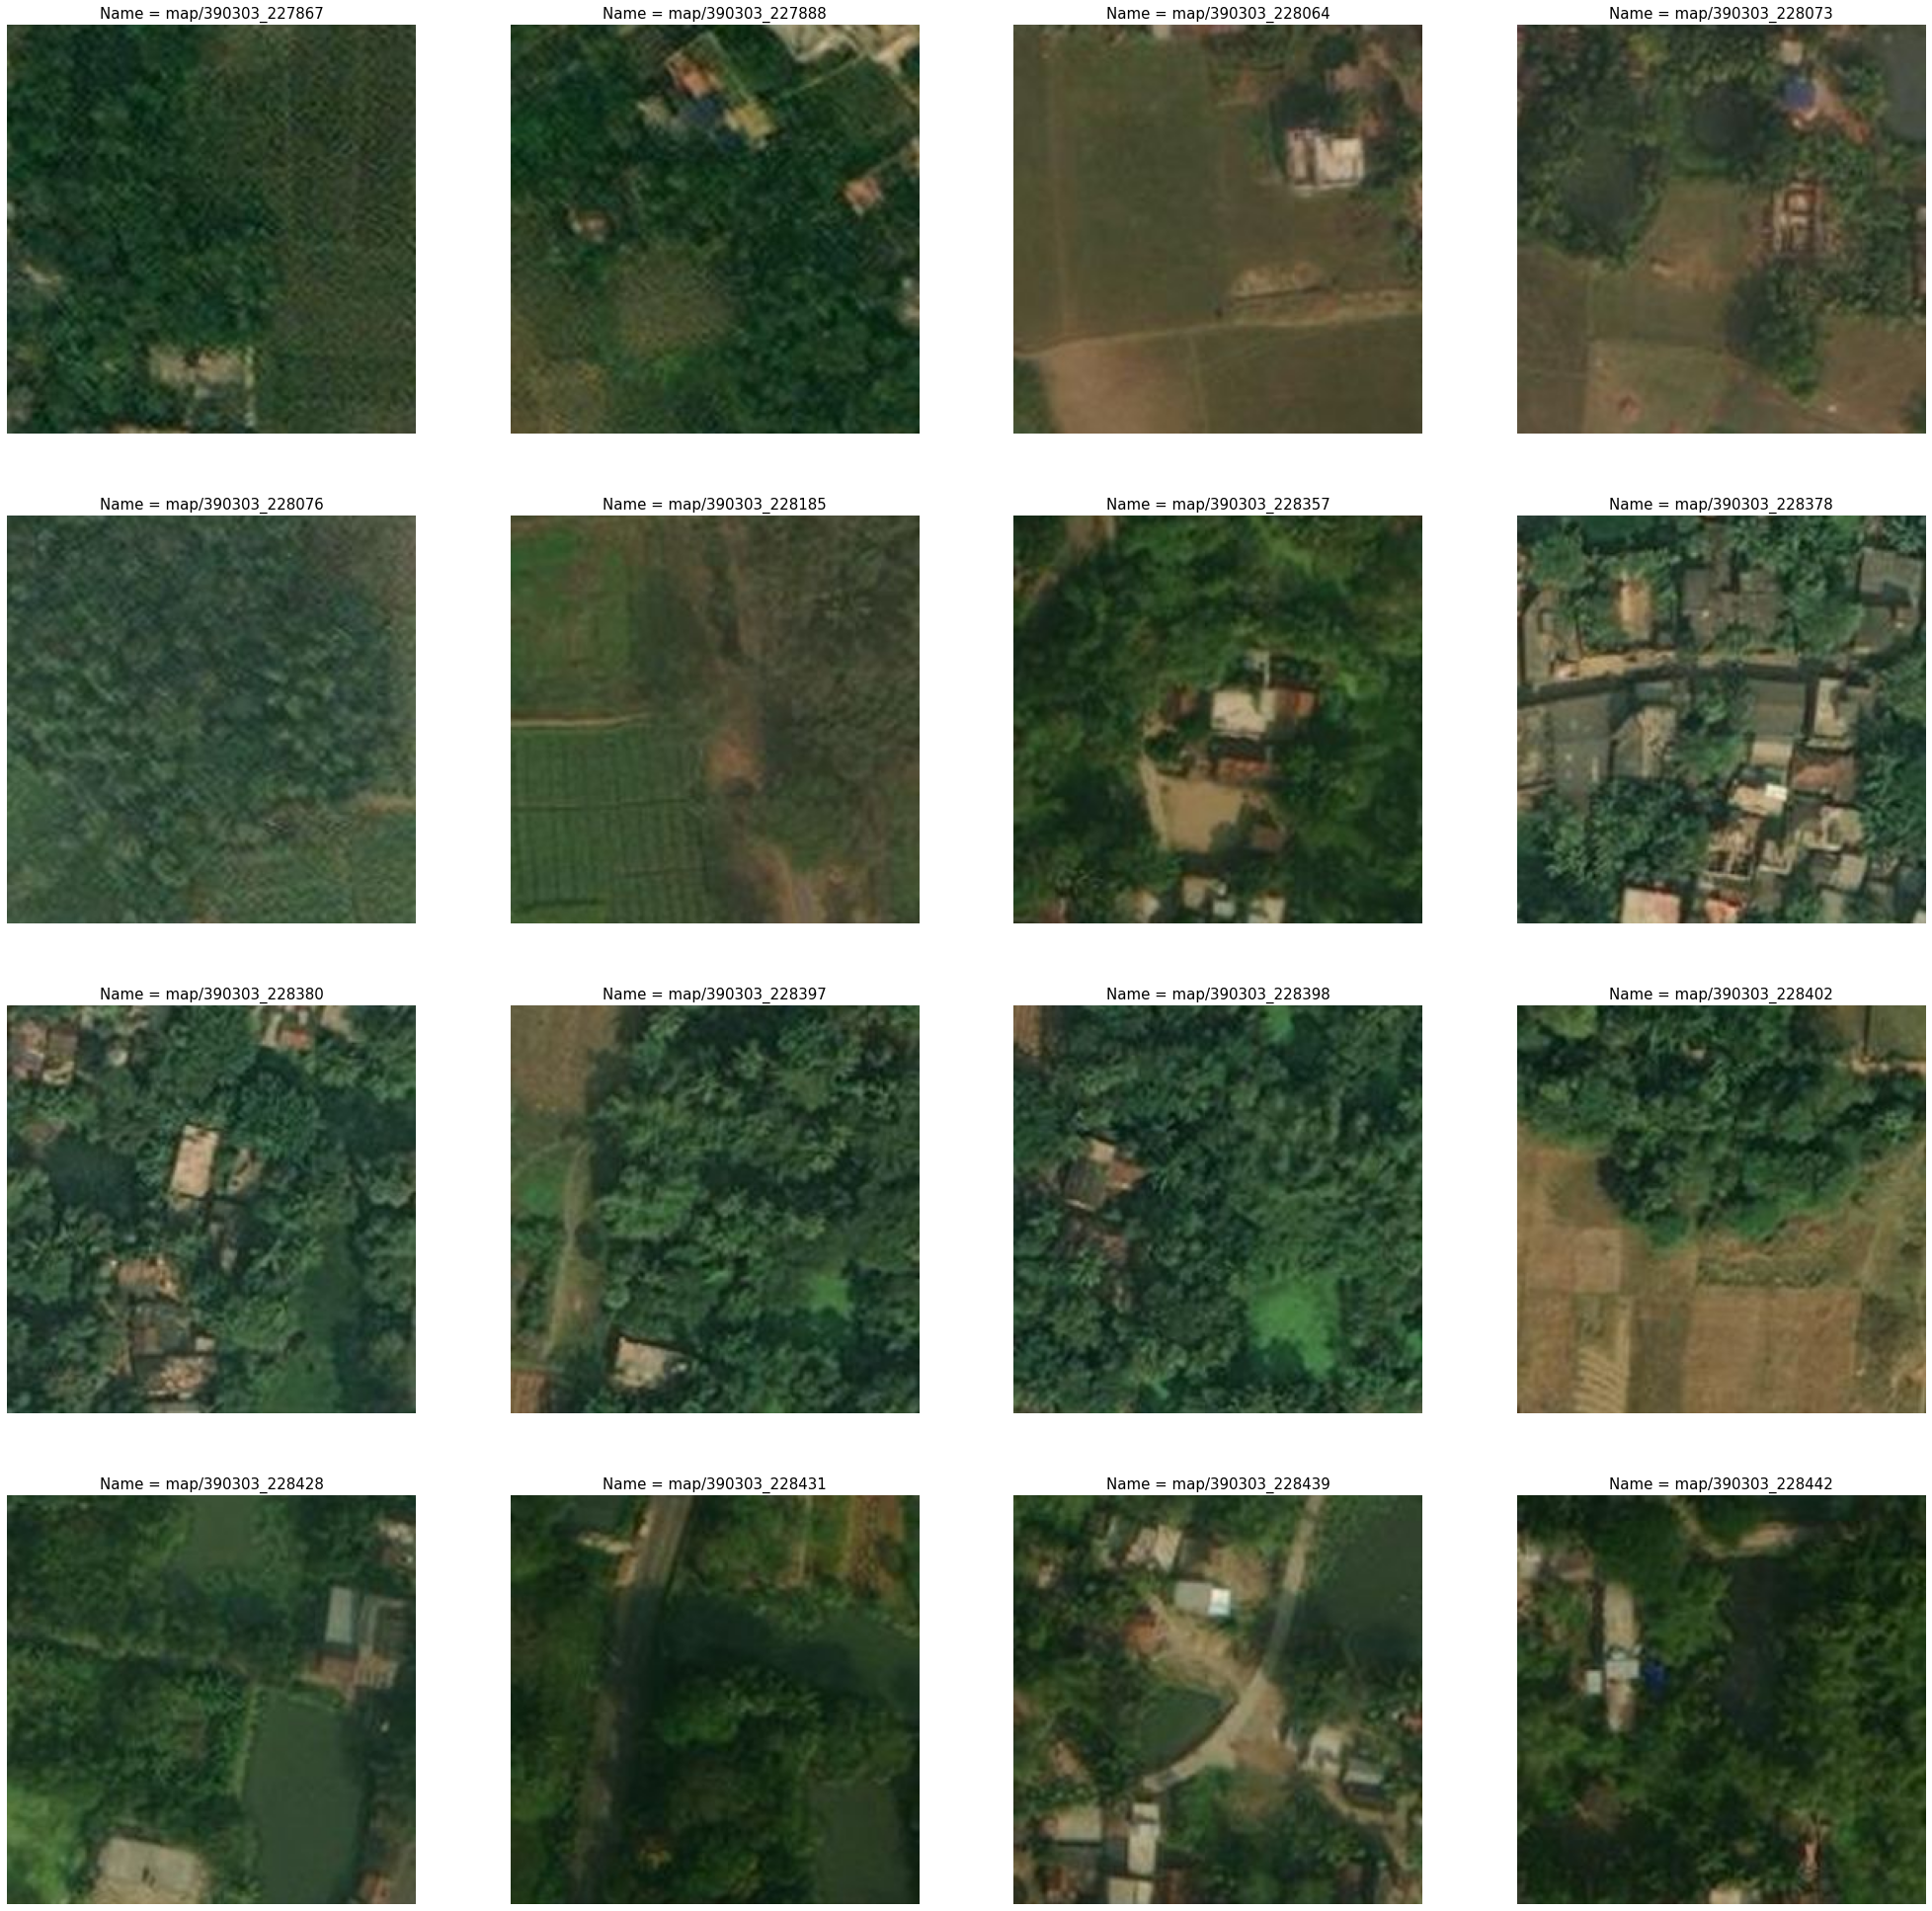

In [29]:
total_img = 16
num_pr = 4 # number per row

counter = 1
plt.figure(figsize=(35,35))
plt.axis('off')
for item in map[:total_img]:
  image = cv2.imread(item, cv2.IMREAD_UNCHANGED)
  #img = cv2.resize(img, (200,60), interpolation = cv2.INTER_AREA)
  #ret,thresh = cv2.threshold(image,127,255,cv2.THRESH_BINARY_INV)
  # firstly perform erosion
  #erosion = cv2.erode(thresh,kernel,iterations = 1)
  # perform dialation
  #dialate = cv2.dilate(erosion,kernel,iterations = 2)
  
  #print(pred)
  #image_bckup = dialate.copy()
  plt.subplot(num_pr, num_pr, counter)
  #print("item => ",item)
  #print("item => ",str(item.split('_')[1]).split('/')[1])
  plt.title("Name = {}".format(str(item.split('.')[0])),fontsize=15).set_color('black')
  plt.axis('off')
  plt.imshow(image[:,:,::-1])#, cmap=plt.get_cmap('gray'))
  counter += 1
  #break
plt.show()

In [27]:
! python -m tensorboard.main --logdir=/path/to/logs

2020-08-25 04:28:51.580380: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.3.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [30]:
#! unzip -qq roads.zip
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision 
from tensorflow.keras import backend as K


In [31]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [48]:
np.random.seed(42)
tf.random.set_seed(42)

## Hyperparameters

IMG_SIZE = 256
EPOCHS = 10
BATCH = 32
LR = 1e-4


PATH = ''

In [49]:
def load_data(path, split=0.1):

  images_list = sorted(glob(os.path.join(path, "map/*")))
  masks_list = sorted(glob(os.path.join(path, "roads/*")))

  tot_size = len(images_list)
  val_size = int(split * tot_size)
  test_size = int(split * tot_size)

  x_train, x_val = train_test_split(images_list, test_size=val_size, random_state=42)
  y_train, y_val = train_test_split(masks_list, test_size=val_size, random_state=42)
  x_train, x_test = train_test_split(x_train, test_size=test_size, random_state=42)
  y_train, y_test = train_test_split(y_train, test_size=test_size, random_state=42)

  return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [50]:

def read_img(path):
    path = path.decode()
    tmp = cv2.imread(path, cv2.IMREAD_COLOR)
    tmp = cv2.resize(tmp, (IMG_SIZE, IMG_SIZE))
    tmp = tmp/255.0
    return tmp



def read_mask(path):
    path = path.decode()
    tmp = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    tmp = cv2.resize(tmp, (IMG_SIZE, IMG_SIZE))
    tmp = tmp/255.0
    tmp = np.expand_dims(tmp, axis=-1)
    return tmp


In [51]:
def tf_parse(a, b):
    def _parse(a, b):
        a = read_img(a)
        b = read_mask(b)
        return a, b

    a, b = tf.numpy_function(_parse, [a, b], [tf.float64, tf.float64])
    a.set_shape([IMG_SIZE, IMG_SIZE, 3])
    b.set_shape([IMG_SIZE, IMG_SIZE, 1])
    return a, b

def tf_dataset(a, b, batch=32):
    data = tf.data.Dataset.from_tensor_slices((a, b))
    data = data.map(tf_parse)
    data = data.batch(batch)
    data = data.repeat()
    return data

In [52]:

(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data("")

print("Training data: ", len(x_train))
print("Validation data: ", len(x_val))
print("Testing data: ", len(x_test))

Training data:  49560
Validation data:  6195
Testing data:  6195


In [53]:
def read_and_rgb(a):
    a = cv2.imread(a)
    a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    return a

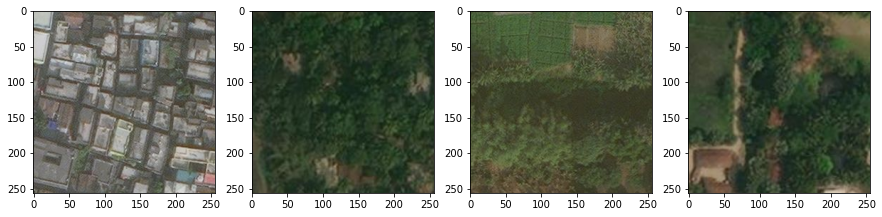

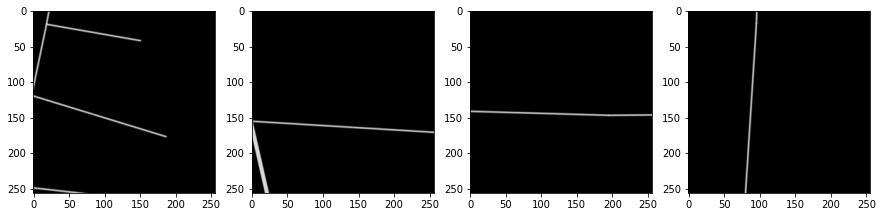

In [54]:
fig = plt.figure(figsize=(15, 15))
x = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(x_train[0]))

x = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(x_train[1]))
imgplot.set_clim(0.0, 0.7)

x = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(x_train[2]))
imgplot.set_clim(0.0, 1.4)

x = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(x_train[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
x = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(y_train[0]))

x = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(y_train[1]))
imgplot.set_clim(0.0, 0.7)

x = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(y_train[2]))
imgplot.set_clim(0.0, 1.4)

x = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(y_train[3]))
imgplot.set_clim(0.0, 1.4)

In [55]:
def model():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.50)
    skip_connection_list = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    fil = [48, 64, 96, 128]
    xt = encoder_output
    for i in range(1, len(skip_connection_list)+1, 1):
        xt_skip = encoder.get_layer(skip_connection_list[-i]).output
        xt = UpSampling2D((2, 2))(xt)
        xt = Concatenate()([xt, xt_skip])
        
        xt = Conv2D(fil[-i], (3, 3), padding="same")(xt)
        xt = BatchNormalization()(xt)
        xt = Activation("relu")(xt)
        
        xt = Conv2D(fil[-i], (3, 3), padding="same")(xt)
        xt = BatchNormalization()(xt)
        xt = Activation("relu")(xt)
        
    xt = Conv2D(1, (1, 1), padding="same")(xt)
    xt = Activation("sigmoid")(xt)
    
    model = Model(inputs, xt)
    return model

In [56]:
model = model()
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 16) 432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 16) 64          Conv1[0][0]                      
_______________________________________________________________________________________

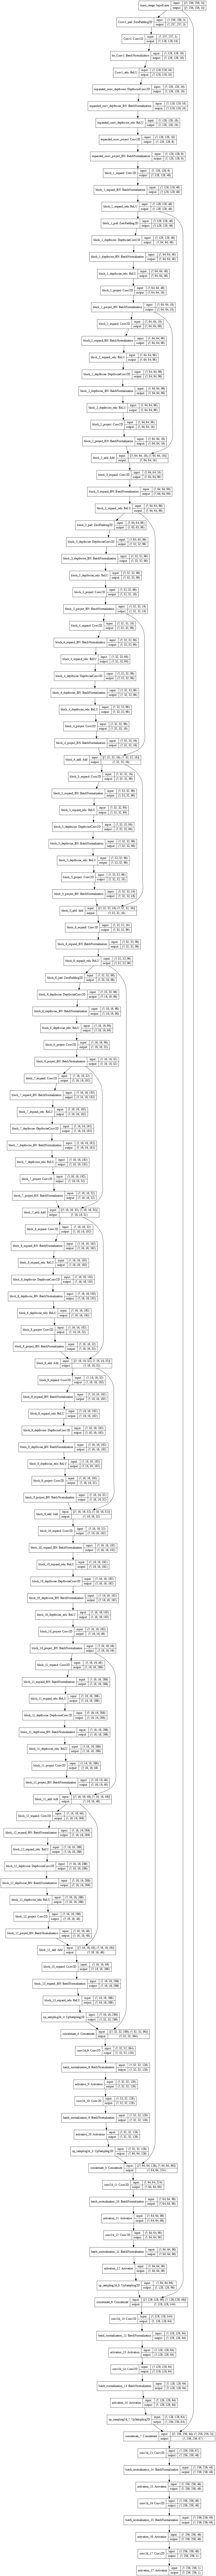

In [57]:
from tensorflow.keras.utils import  plot_model as pm  #plotting the model structure
pm(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=60)

In [58]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [59]:
train_data = tf_dataset(x_train, y_train, batch=BATCH)
valid_data = tf_dataset(x_val, y_val, batch=BATCH)

In [60]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [61]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras

# for storing logs into tensorboard
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")


callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    ModelCheckpoint("./model_checkpoint", monitor='val_loss'),
    keras.callbacks.TensorBoard(log_dir=logdir)
]

In [62]:
train_steps = len(x_train)//BATCH
valid_steps = len(x_val)//BATCH

if len(x_train) % BATCH != 0:
    train_steps += 1
if len(x_val) % BATCH != 0:
    valid_steps += 1

In [ ]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/10
  45/1549 [..............................] - ETA: 42:23 - loss: 0.9615 - dice_coef: 0.0385 - recall_1: 0.5285 - precision_1: 0.0554

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,7))
legend_acc = []
for item in history.history.keys():
  if item.split('_')[-1:] == ['acc']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(history.history[item])
plt.ylabel('Accuracy ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper left')
plt.show()

plt.figure(figsize=(12,7))
legend_acc = []
for item in history.history.keys():
  if item.split('_')[-1:] == ['loss']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(history.history[item])
plt.ylabel('Loss ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper right')
plt.show()
plt.savefig('acc_BuildingDetectionUNet_jimutmap_3.png')

In [ ]:
# https://www.tensorflow.org/tensorboard/graphs
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
model.save_weights("JimutmapRoads_10e.h5")
model.save("JimutmapRoads_with_weight_10e.h5")


In [ ]:
# Run this module only while loading the pre-trained model.
model = load_model('JimutmapRoads_with_weight_10e.h5',custom_objects={'dice_loss': dice_loss,'dice_coef':dice_coef})
model.summary()


In [ ]:
test_data = tf_dataset(x_test, y_test, batch=BATCH)

test_steps = (len(x_test)//BATCH)
if len(x_test) % BATCH != 0:
    test_steps += 1

model.evaluate(test_data, steps=test_steps)



In [ ]:
def read_img(path):
    xt = cv2.imread(path, cv2.IMREAD_COLOR)
    xt = cv2.cvtColor(xt, cv2.COLOR_BGR2RGB)
    xt = cv2.resize(xt, (IMG_SIZE, IMG_SIZE))
    xt = xt/255.0
    return xt

def read_mask(path):
    xt = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    xt = cv2.resize(xt, (IMG_SIZE, IMG_SIZE))
    xt = np.expand_dims(xt, axis=-1)
    xt = xt/255.0
    return xt

def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [ ]:
for i, (a, b) in enumerate(zip(x_test[10:30], y_test[10:30])):
    a = read_img(a)
    b = read_mask(b)
    y_pred = model.predict(np.expand_dims(a, axis=0))[0] > 0.5
    #print(y_pred.shape)
    h, w, _ = a.shape
    white_line = np.ones((h, 10, 3))
    mask_red = np.ones((h,w,3))
    mask_red[:,:,0] = a[:,:,0]*.5
    mask_red[:,:,1] = a[:,:,1]*0.5 
    mask_red[:,:,2] = y_pred[:,:,0]*.5 + a[:,:,2]*0.5  
    mask_red = mask_red*2
    mask_red = np.clip(mask_red, 0, 1)
    all_images = [
        a, white_line,
        mask_parse(b), white_line,
        mask_red
        #mask_parse(y_pred)*0.5+a*0.5
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    x = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
